# Model search

## Getting started

With training sets generated and hyperparameter sets designed, its time to search for a best performing model setup. Models will be evaluated at three levels: **1)** their ability to identify scenes with seals, **2)** retrieve seal haul outs **3)** and count individual seals. Current training classes can be displayed by running the following cells.

In [37]:
# import required packages
import os
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.dpi']= 400


# display class names
class_names = sorted([subdir for subdir in os.listdir('./training_sets/training_set_vanilla/training')])
print(class_names)

['crabeater', 'crack', 'emperor', 'glacier', 'ice-sheet', 'marching-emperor', 'open-water', 'other', 'pack-ice', 'rock', 'weddell']


## Visualizing training images

To get a better sense for what the training set is like, the next cell will display a few random images from the training classes. Displayed images are extracted from a pool of ~70000 training images. 

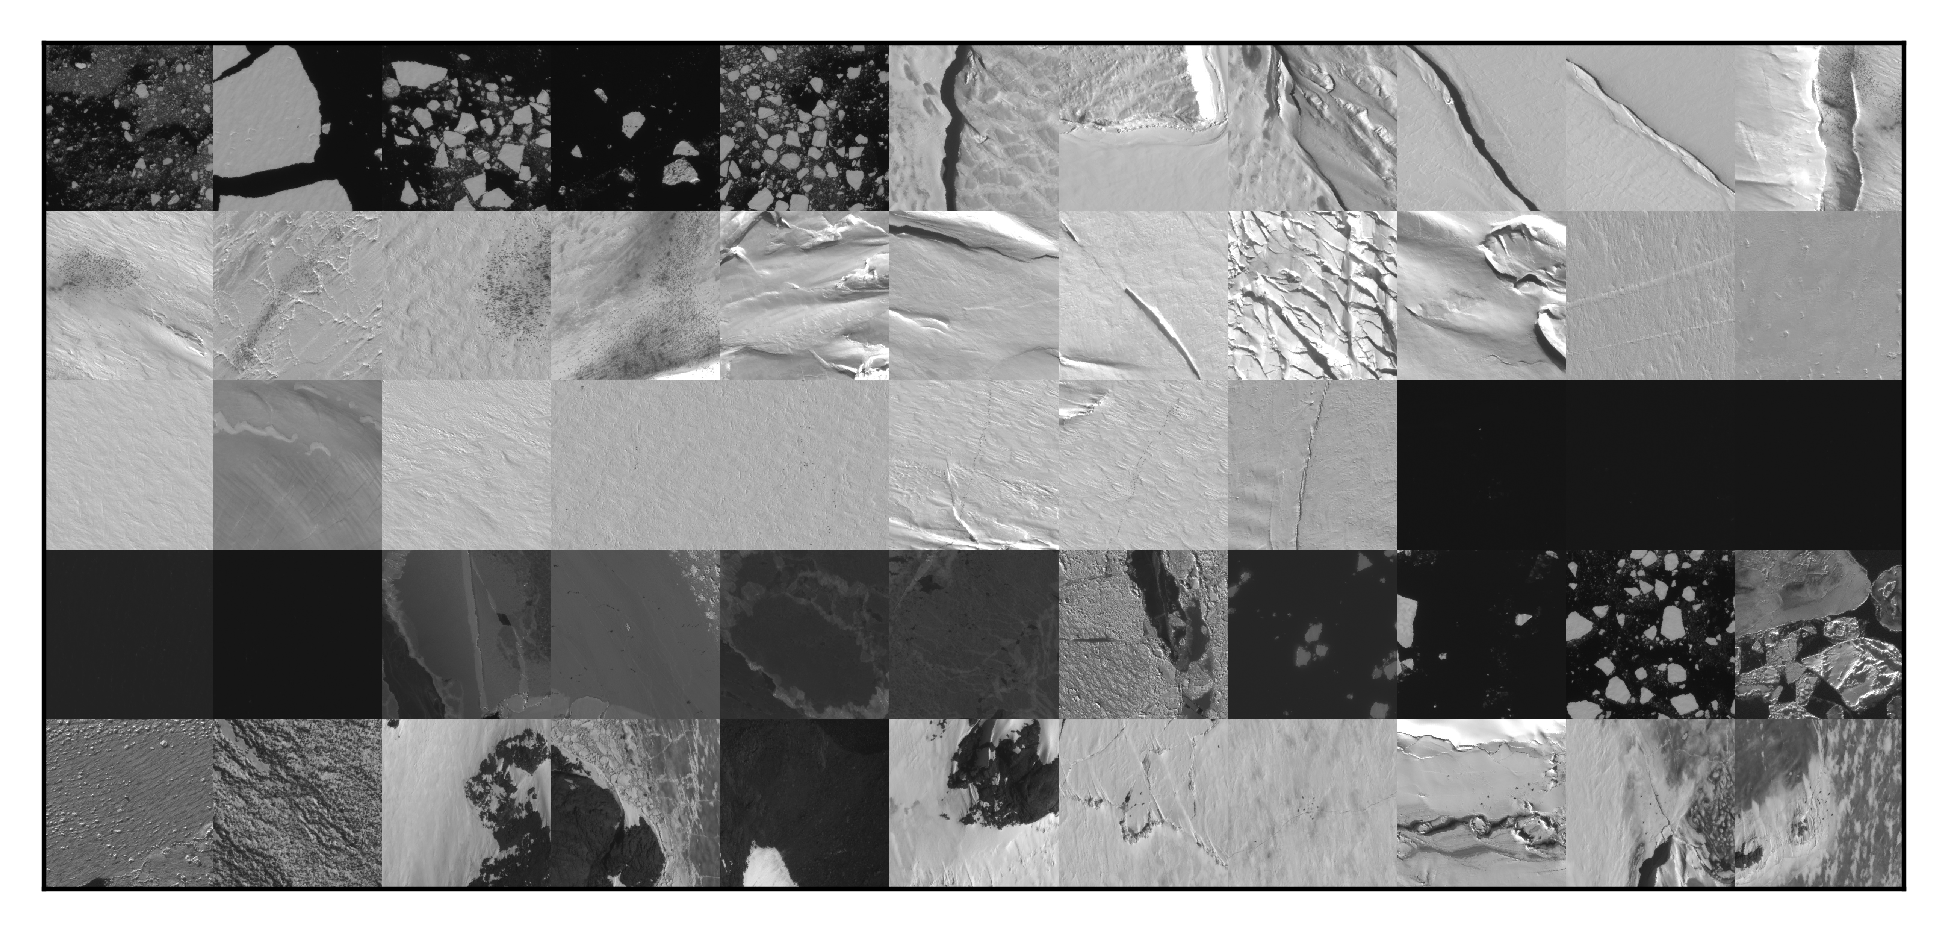

In [41]:
# store images
images = []

# loop over labels
for label in class_names:
    for path, _, files in os.walk('./training_sets/training_set_vanilla/training/{}'.format(label)):
        files = np.random.choice(files, 5)
        for filename in files:
            images.append(np.asarray(Image.open(os.path.join(path, filename))))

images = np.array(images)

# display images 
ncols=len(class_names)
nindex, height, width, intensity = images.shape
nrows = nindex//ncols
assert nindex == nrows*ncols
result = (images.reshape(nrows, ncols, height, width, intensity)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncols, intensity))

plt.imshow(result)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()
    


## Training

The first step to find a best performing model is to train different model setups using our training set. To keep track of which combinations we have tried and, later on, performance scores at the three levels described above, we will start by creating a pandas DataFrame with model definitions.

In [5]:
# generate model combinations
combinations = {'model_architecture': ['Resnet18' for ele in range(4)] + ['NasnetA' for ele in range(4)],
                'training_dir': ['training_set_vanilla', 'training_set_multiscale_A'] * 4,
                'hyperparameter_set': ['A' for ele in range(4)] + ['B' for ele in range(4)],
                'cv_weights': ['NO', 'NO', 'A', 'A'] * 2,
                'output_name': ['model{}'.format(i) for i in range(1,9)]}

combinations = pd.DataFrame(combinations)

# create folders for resulting files
for mdl in combinations['output_name']:
    if not os.path.exists("./saved_models/{}".format(mdl)):
        os.makedirs("./saved_models/{}".format(mdl)) 


We can then provide model combinations created above as arguments to the training script, *train_sealnet.py*. A list of required arguments can be displayed by running the cell below.

In [ ]:
%run train_sealnet.py -h

In [4]:
# iterate over combinations
for row in combinations.iterrows():
    t_dir, arch, hyp_st, cv_wgt, out = row[1]['training_dir'], row[1]['model_architecture'], row[1]['hyperparameter_set'], row[1]['cv_weights'], row[1]['output_name']
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models/{}/'.format(out)): 
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet.py --training_dir=$t_dir --model_architecture=$arch --hyperparameter_set=$hyp_st --cv_weights=$cv_wgt --output_name=$out
    
      

NameError: name 'combinations' is not defined

## Validation - Haulout level

We can now load the models we just trained to get measurements of precision and recall for all positive classes. For every model combination we trained, *validate_sealnet.py* will run a full validation round and write given label/correct label pairs to a .csv file. The resulting .csv file is then imported by an R script, *plot_confusion_matrix.R*, which saves a confusion matrix figure and a .csv spreadsheet with precision and recall for all classes of interest. 

In [6]:
# DataFrame to combine all metrics 
comb_prec_recall = pd.DataFrame()

# iterate over trained models
for row in combinations.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, out = row[1]['training_dir'], row[1]['model_architecture'], row[1]['hyperparameter_set'], row[1]['output_name']
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models/{}/'.format(out)): 
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        # run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch --hyperparameter_set=$hyp_st --input_name=$out
        
        # extract performance
        !Rscript plot_confusion_matrix.R $out
        
        # accumulate performance scores
        comb_prec_recall = comb_prec_recall.append(pd.read_csv('./saved_models/{}/{}_prec_recall.csv'.format(out, out)))
    
    
# Write combined metrics to csv
comb_prec_recall.to_csv('./saved_models/pooled_prec_recall.csv')

# Plot combined metrics
!Rscript plot_comparison.R
    


validating model1

Validation complete in 0.0h 0m 55s
Validation Acc: 0.901639
Loading required package: methods

validating model2

Validation complete in 0.0h 1m 21s
Validation Acc: 0.866529
Loading required package: methods

validating model3

Validation complete in 0.0h 0m 28s
Validation Acc: 0.867174
Loading required package: methods

validating model4

Validation complete in 0.0h 0m 32s
Validation Acc: 0.734478
Loading required package: methods

validating model5

Validation complete in 0.0h 5m 10s
Validation Acc: 0.925649
Loading required package: methods

validating model6

Validation complete in 0.0h 5m 5s
Validation Acc: 0.921002
Loading required package: methods
Using Unnamed..0, model_name as id variables
null device 
          1 


In [15]:
%mkdir classified_images
for x in class_names:
    dir = './classified_images/' + x
    %mkdir -v $dir
    
%run predict_sealnet.py "training_set" "NasnetA" "model5" "./to_classify"

mkdir: cannot create directory ‘classified_images’: File exists
mkdir: cannot create directory ‘./classified_images/crabeater’: File exists
mkdir: cannot create directory ‘./classified_images/crack’: File exists
mkdir: cannot create directory ‘./classified_images/emperor’: File exists
mkdir: cannot create directory ‘./classified_images/glacier’: File exists
mkdir: cannot create directory ‘./classified_images/ice-sheet’: File exists
mkdir: cannot create directory ‘./classified_images/marching-emperor’: File exists
mkdir: cannot create directory ‘./classified_images/open-water’: File exists
mkdir: cannot create directory ‘./classified_images/other’: File exists
mkdir: cannot create directory ‘./classified_images/pack-ice’: File exists
mkdir: cannot create directory ‘./classified_images/rock’: File exists
mkdir: cannot create directory ‘./classified_images/weddell’: File exists
predicted 8203.jpg as: pack-ice
predicted 8164.jpg as: pack-ice
predicted 8294.jpg as: pack-ice
predicted 43543.

predicted 8225.jpg as: pack-ice
predicted 43786.jpg as: pack-ice
predicted 27730.jpg as: crabeater
predicted 8476.jpg as: pack-ice
predicted 8346.jpg as: pack-ice
predicted 8182.jpg as: pack-ice
predicted 8320.jpg as: pack-ice
predicted 8153.jpg as: pack-ice
predicted 43732.jpg as: pack-ice
predicted 8430.jpg as: pack-ice
predicted 8216.jpg as: other
predicted 8202.jpg as: pack-ice
predicted 6679.jpg as: weddell
predicted 43582.jpg as: pack-ice
predicted 8176.jpg as: pack-ice
predicted 29695.jpg as: crabeater
predicted 8419.jpg as: pack-ice
predicted 43738.jpg as: pack-ice
predicted 43792.jpg as: open-water
predicted 8471.jpg as: pack-ice
predicted 43515.jpg as: pack-ice
predicted 8411.jpg as: pack-ice
predicted 6576.jpg as: weddell
predicted 43765.jpg as: pack-ice
predicted 43541.jpg as: rock
predicted 28158.jpg as: crabeater
predicted 8187.jpg as: pack-ice
predicted 8321.jpg as: pack-ice
predicted 8110.jpg as: weddell
predicted 8277.jpg as: pack-ice
predicted 8264.jpg as: pack-ice
pr

predicted 8308.jpg as: pack-ice
predicted 7377.jpg as: weddell
predicted 29823.jpg as: crabeater
predicted 43591.jpg as: pack-ice
predicted 29215.jpg as: crabeater
predicted 7508.jpg as: weddell
predicted 28283.jpg as: crabeater
predicted 8408.jpg as: pack-ice
predicted 43602.jpg as: pack-ice
predicted 5767.jpg as: weddell
predicted 8220.jpg as: pack-ice
predicted 28121.jpg as: crabeater
predicted 8170.jpg as: pack-ice
predicted 8291.jpg as: pack-ice
predicted 8337.jpg as: pack-ice
predicted 8285.jpg as: pack-ice
predicted 5398.jpg as: weddell
predicted 43800.jpg as: pack-ice
predicted 5651.jpg as: weddell
predicted 43596.jpg as: pack-ice
predicted 27805.jpg as: crabeater
predicted 43528.jpg as: pack-ice
predicted 43552.jpg as: pack-ice
predicted 8359.jpg as: pack-ice
predicted 8156.jpg as: pack-ice
predicted 31501.jpg as: crabeater
predicted 8221.jpg as: pack-ice
predicted 29181.jpg as: crabeater
predicted 1628.jpg as: weddell
predicted 43589.jpg as: pack-ice
predicted 29123.jpg as: c